# IMPORTING LIBRARIES


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# INPUT AND NORMALIZATION


In [2]:
# Loading the data
file_path = "send.xlsx"
df = pd.read_excel(file_path)
confirmed_cases = df['Confirmed Cases'].values
df.rename(columns={'Confirmed Cases': 'E', 'Active Cases': 'I', 'Cured/Discharged': 'R', 'Death': 'D'}, inplace=True)

E = df['E'].values
I = df['I'].values
R = df['R'].values
D = df['D'].values
mean_E = np.mean(E)
std_E = np.std(E)
mean_I = np.mean(I)
std_I = np.std(I)
mean_R = np.mean(R)
std_R = np.std(R)
mean_D = np.mean(D)
std_D = np.std(D)

# Calculating z-scores
def calculate_z_scores(data):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = (data - mean) / std
    return z_scores

E_z_scores = calculate_z_scores(E)
I_z_scores = calculate_z_scores(I)
R_z_scores = calculate_z_scores(R)
D_z_scores = calculate_z_scores(D)

# Converting z-scores to torch tensors
E_z = torch.tensor(E_z_scores, dtype=torch.float32).reshape(-1, 1)
I_z = torch.tensor(I_z_scores, dtype=torch.float32).reshape(-1, 1)
R_z = torch.tensor(R_z_scores, dtype=torch.float32).reshape(-1, 1)
D_z = torch.tensor(D_z_scores, dtype=torch.float32).reshape(-1, 1)

initial_S = 138.31e7
delta_E = confirmed_cases[1:] - confirmed_cases[:-1]
conversion_rate = delta_E / initial_S
S = initial_S - confirmed_cases
# Clip alpha values to be non-negative
alpha_values = np.clip(conversion_rate, 0, None)

print(E_z)
print(I_z)
print(R_z)
print(D_z)

tensor([[-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3044],
        [-1.3043],
        [-1.3043],
        [-1.3043],
        [-1.3042],
        [-1.3042],
        [-1.3042],
        [-1.3041],
        [-1.3041],
        [-1.3041],
        [-1.3040],
        [-1.3039],
        [-1.3039],
        [-1.3038],
        [-1.3037],
        [-1.3037],
        [-1.3036],
        [-1.3036],
        [-1.3035],
        [-1.3034],
        [-1.3033],
        [-1.3032],
        [-1.3031],
        [-1.3030],
        [-1.3029],
        [-1.3028],
        [-1.3027],
        [-1.3026],
        [-1.3025],
        [-1.3024],
        [-1.3023],
        [-1.3021],
        [-1.

# NEURAL NETWORK MODEL


In [3]:
class ParameterModel(nn.Module):
    def __init__(self):
        super(ParameterModel, self).__init__()
        self.fc1 = nn.Linear(1, 35)
        self.fc2 = nn.Linear(35, 50)
        self.fc3 = nn.Linear(50, 30)
        self.fc4 = nn.Linear(30, 30)
        self.fc5 = nn.Linear(30, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        #print(f"After fc1: {x}")
        x = self.relu(self.fc2(x))
        #print(f"After fc2: {x}")
        x = self.relu(self.fc3(x))
       # print(f"After fc3: {x}")
        x = self.relu(self.fc4(x))
       # print(f"After fc4: {x}")
        x = self.sigmoid(self.fc5(x))
       # print(f"After fc5: {x}")
        return x


# RUNGE KUTTA METHOD FOR SOLVING ODEs


In [4]:
# Define the SEIRD model using the fourth-order Runge-Kutta method
def seird_model_rk4(E, I, R, D, beta, gamma, mu, dt=1):
    def derivatives(E, I, R, D, beta, gamma, mu):
        dE_dt = -beta * E - gamma * E  - mu * E
        dI_dt = beta * E
        dR_dt = gamma * E
        dD_dt = mu * E
        return dE_dt, dI_dt, dR_dt, dD_dt

    K1_E, K1_I, K1_R, K1_D = derivatives(E, I, R, D, beta, gamma, mu)
    K2_E, K2_I, K2_R, K2_D = derivatives(E + 0.5 * dt * K1_E, I + 0.5 * dt * K1_I, R + 0.5 * dt * K1_R, D + 0.5 * dt * K1_D, beta, gamma, mu)
    K3_E, K3_I, K3_R, K3_D = derivatives(E + 0.5 * dt * K2_E, I + 0.5 * dt * K2_I, R + 0.5 * dt * K2_R, D + 0.5 * dt * K2_D, beta, gamma, mu)
    K4_E, K4_I, K4_R, K4_D = derivatives(E + dt * K3_E, I + dt * K3_I, R + dt * K3_R, D + dt * K3_D, beta, gamma, mu)

    E_next = E + (dt / 6) * (K1_E + 2 * K2_E + 2 * K3_E + K4_E)
    I_next = I + (dt / 6) * (K1_I + 2 * K2_I + 2 * K3_I + K4_I)
    R_next = R + (dt / 6) * (K1_R + 2 * K2_R + 2 * K3_R + K4_R)
    D_next = D + (dt / 6) * (K1_D + 2 * K2_D + 2 * K3_D + K4_D)

    return E_next, I_next, R_next, D_next

# LOSS FUNCTION CALCULATION


In [7]:
# Loss function
def loss_function(E_true, I_true, R_true, D_true, E_pred, I_pred, R_pred, D_pred, omega_E, omega_I, omega_R, omega_D, omega_params):
    loss_E = torch.mean(torch.abs(E_true - E_pred) ** 2) * omega_E
    loss_I = torch.mean(torch.abs(I_true - I_pred) ** 2) * omega_I
    loss_R = torch.mean(torch.abs(R_true - R_pred) ** 2) * omega_R
    loss_D = torch.mean(torch.abs(D_true - D_pred) ** 2) * omega_D
    regularization_loss = omega_params * (torch.sum(beta_model.fc1.weight**2) + torch.sum(gamma_model.fc1.weight**2) + torch.sum(mu_model.fc1.weight**2))
    total_loss = loss_E + loss_I + loss_R + loss_D + regularization_loss
    return total_loss

# TRAINING THE MODEL

In [9]:
# Train the SEIRD model
def train_SEIRD_model(max_epoch, E_data, I_data, R_data, D_data, beta_model, gamma_model, mu_model, omega_S, omega_I, omega_R, omega_D, omega_params):
    optimizer = optim.Adam(list(beta_model.parameters()) + list(gamma_model.parameters()) + list(mu_model.parameters()), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.95)

    total_loss_values = []
    log_loss_values = []

    for epoch in range(max_epoch):
        optimizer.zero_grad()

        beta = beta_model(E_data)
        gamma = gamma_model(I_data)
        mu = mu_model(R_data)

        E_pred, I_pred, R_pred, D_pred = seird_model_rk4(E_data, I_data, R_data, D_data, beta, gamma, mu)
        loss = loss_function(E_data, I_data, R_data, D_data, E_pred, I_pred, R_pred, D_pred, omega_E, omega_I, omega_R, omega_D, omega_params)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss_values.append(loss.item())
        log_loss_values.append(torch.log(loss).item())

        if epoch % 1 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return total_loss_values, log_loss_values

# Hyperparameters
max_epoch = 100
omega_E = 1.0
omega_I = 1.0
omega_R = 1.0
omega_D = 1.0
omega_params = 0.0005

# Initialize models
beta_model = ParameterModel()
gamma_model = ParameterModel()
mu_model = ParameterModel()

# Train the models
total_loss_values, log_loss_values = train_SEIRD_model(max_epoch, E_z, I_z, R_z, D_z, beta_model, gamma_model, mu_model, omega_E, omega_I, omega_R, omega_D, omega_params)

# Function to predict SEIRD values
def predict_seird(E, I, R, D, beta_model, gamma_model, mu_model):
    beta = beta_model(E)
    gamma = gamma_model(I)
    mu = mu_model(R)
    E_pred, I_pred, R_pred, D_pred = seird_model_rk4(E, I, R, D, beta, gamma, mu)
    return E_pred, I_pred, R_pred, D_pred

# Predict SEIRD values
E_pred, I_pred, R_pred, D_pred = predict_seird(E_z, I_z, R_z, D_z, beta_model, gamma_model, mu_model)

# Convert predicted values from tensors to numpy arrays
E_pred = E_pred.detach().numpy()
I_pred = I_pred.detach().numpy()
R_pred = R_pred.detach().numpy()
D_pred = D_pred.detach().numpy()

Epoch 0, Loss: 0.7154847979545593
Epoch 1, Loss: 0.7139396071434021
Epoch 2, Loss: 0.7122954726219177
Epoch 3, Loss: 0.7105458974838257
Epoch 4, Loss: 0.7086799144744873
Epoch 5, Loss: 0.7066912651062012
Epoch 6, Loss: 0.7046246528625488
Epoch 7, Loss: 0.7024233937263489
Epoch 8, Loss: 0.7000585794448853
Epoch 9, Loss: 0.6975017786026001
Epoch 10, Loss: 0.694747805595398
Epoch 11, Loss: 0.6917893886566162
Epoch 12, Loss: 0.6885720491409302
Epoch 13, Loss: 0.6850330233573914
Epoch 14, Loss: 0.681145429611206
Epoch 15, Loss: 0.6768745183944702
Epoch 16, Loss: 0.6721100807189941
Epoch 17, Loss: 0.6668519377708435
Epoch 18, Loss: 0.6610396504402161
Epoch 19, Loss: 0.6546253561973572
Epoch 20, Loss: 0.6476582288742065
Epoch 21, Loss: 0.6399295926094055
Epoch 22, Loss: 0.6314627528190613
Epoch 23, Loss: 0.6221359968185425
Epoch 24, Loss: 0.6117669343948364
Epoch 25, Loss: 0.600291907787323
Epoch 26, Loss: 0.5876498222351074
Epoch 27, Loss: 0.5735869407653809
Epoch 28, Loss: 0.558289468288421

In [10]:
def denormalize_data(normalized_data, mean, std):
    denormalized_data = (normalized_data * std) + mean
    return denormalized_data
# Denormalize predicted values
E_pred_denormalized = denormalize_data(E_pred, mean_E, std_E)
I_pred_denormalized = denormalize_data(I_pred, mean_I, std_I)
R_pred_denormalized = denormalize_data(R_pred, mean_R, std_R)
D_pred_denormalized = denormalize_data(D_pred, mean_D, std_D)


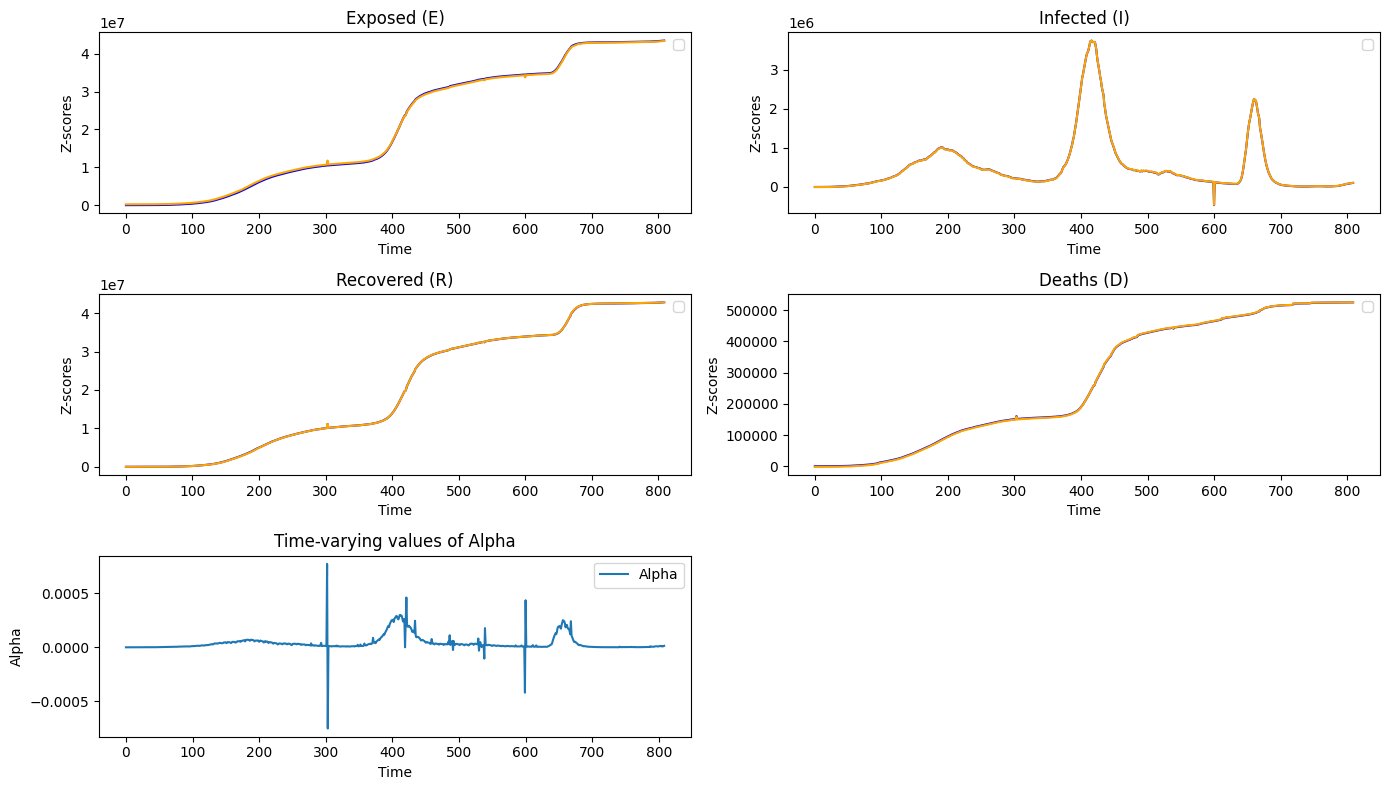

In [11]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 8))

plt.subplot(3, 2, 1)
plt.plot(E, color='blue')
plt.plot(E_pred_denormalized, color='orange')
plt.title('Exposed (E)')
plt.xlabel('Time')
plt.ylabel('Z-scores')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(I, color='blue')
plt.plot(I_pred_denormalized, color='orange')
plt.title('Infected (I)')
plt.xlabel('Time')
plt.ylabel('Z-scores')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(R, color='blue')
plt.plot(R_pred_denormalized, color='orange')
plt.title('Recovered (R)')
plt.xlabel('Time')
plt.ylabel('Z-scores')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(D, color='blue')
plt.plot(D_pred_denormalized, color='orange')
plt.title('Deaths (D)')
plt.xlabel('Time')
plt.ylabel('Z-scores')
plt.legend()


plt.subplot(3, 2, 5)
plt.plot(conversion_rate, label='Alpha')
plt.title('Time-varying values of Alpha')
plt.xlabel('Time')
plt.ylabel('Alpha')
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-12-bc2c477578f4>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  E_pred_tensor = torch.tensor(E_z, dtype=torch.float32)
<ipython-input-12-bc2c477578f4>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I_pred_tensor = torch.tensor(I_z, dtype=torch.float32)
<ipython-input-12-bc2c477578f4>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R_pred_tensor = torch.tensor(R_z, dtype=torch.float32)


Predicted Beta values (first array):
 [[0.00307878]
 [0.00307878]
 [0.00307879]
 [0.0030788 ]
 [0.0030788 ]
 [0.00307881]
 [0.00307881]
 [0.00307883]
 [0.00307884]
 [0.00307887]
 [0.00307892]
 [0.00307895]
 [0.00307898]
 [0.003079  ]
 [0.00307906]
 [0.0030791 ]
 [0.00307919]
 [0.00307922]
 [0.00307927]
 [0.00307942]
 [0.00307954]
 [0.0030797 ]
 [0.00307986]
 [0.00308016]
 [0.00308038]
 [0.00308072]
 [0.0030809 ]
 [0.00308127]
 [0.00308153]
 [0.00308186]
 [0.00308237]
 [0.00308281]
 [0.00308319]
 [0.00308378]
 [0.00308431]
 [0.00308477]
 [0.00308526]
 [0.00308574]
 [0.00308639]
 [0.00308715]
 [0.00308779]
 [0.00308847]
 [0.00308916]
 [0.00308998]
 [0.00309067]
 [0.00309165]
 [0.00309233]
 [0.00309308]
 [0.00309401]
 [0.00309484]
 [0.00309582]
 [0.00309694]
 [0.00309823]
 [0.00309948]
 [0.00310139]
 [0.00310283]
 [0.00310458]
 [0.00310624]
 [0.00310787]
 [0.00310947]
 [0.00311154]
 [0.00311331]
 [0.00311504]
 [0.00311687]
 [0.00311883]
 [0.00312078]
 [0.00312324]
 [0.00312582]
 [0.003128

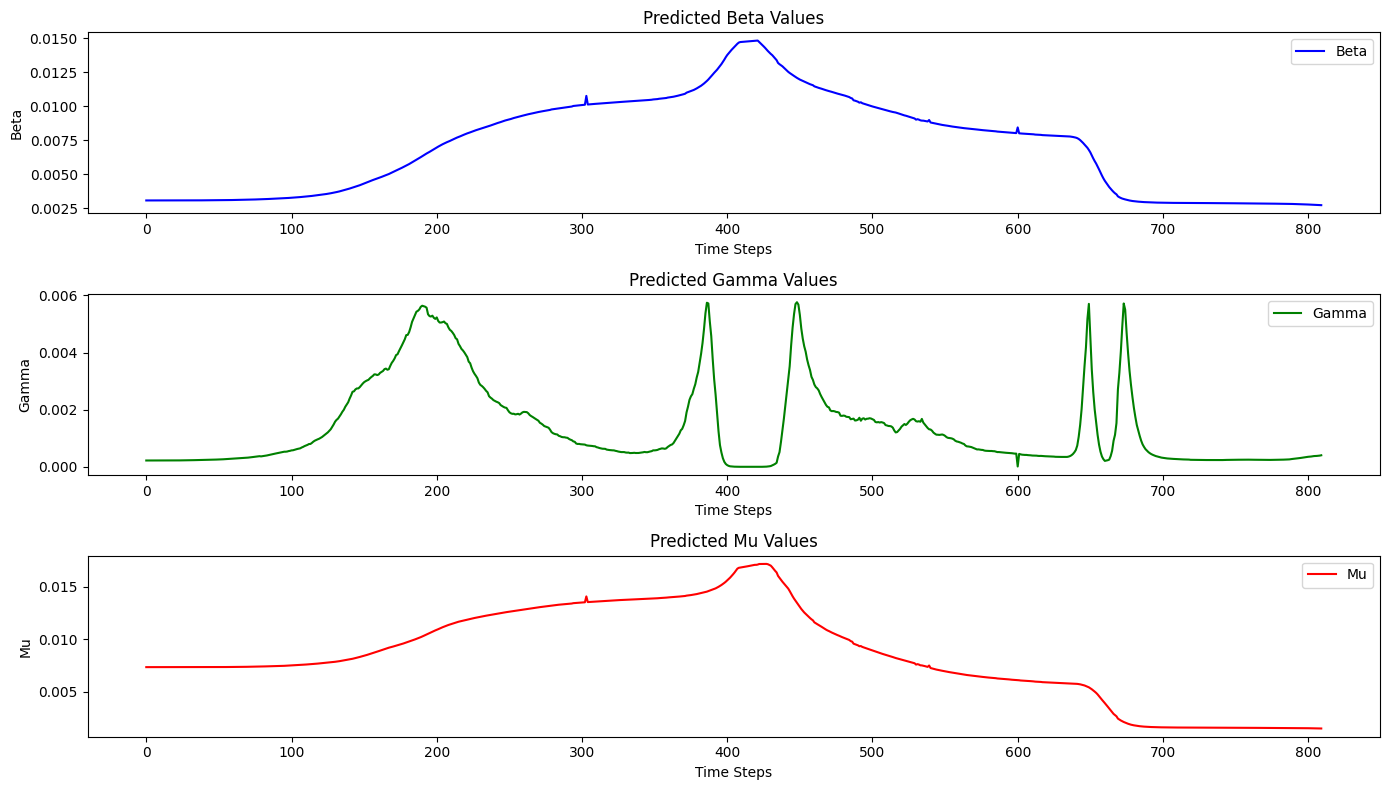

In [12]:
import torch
import matplotlib.pyplot as plt

# Ensure the models are in evaluation mode
beta_model.eval()
gamma_model.eval()
mu_model.eval()

# Use the original input data for prediction
E_pred_tensor = torch.tensor(E_z, dtype=torch.float32)
I_pred_tensor = torch.tensor(I_z, dtype=torch.float32)
R_pred_tensor = torch.tensor(R_z, dtype=torch.float32)

# Get the predicted beta, gamma, and mu values for each time step
with torch.no_grad():  # Disable gradient calculation
    beta_values = beta_model(E_pred_tensor).numpy()
    gamma_values = gamma_model(I_pred_tensor).numpy()
    mu_values = mu_model(R_pred_tensor).numpy()


# Print the predicted values
print("Predicted Beta values (first array):\n", beta_values)
print("Predicted Gamma values (first array):\n", gamma_values)
print("Predicted Mu values (first array):\n", mu_values)

# Plot the predicted values
time_steps = range(len(E_z))  # Assuming time steps are sequential indices

plt.figure(figsize=(14, 8))

# Plot Beta values
plt.subplot(3, 1, 1)
plt.plot(time_steps, beta_values, label='Beta', color='blue')
plt.xlabel('Time Steps')
plt.ylabel('Beta')
plt.title('Predicted Beta Values')
plt.legend()

# Plot Gamma values
plt.subplot(3, 1, 2)
plt.plot(time_steps, gamma_values, label='Gamma', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Gamma')
plt.title('Predicted Gamma Values')
plt.legend()

# Plot Mu values
plt.subplot(3, 1, 3)
plt.plot(time_steps, mu_values, label='Mu', color='red')
plt.xlabel('Time Steps')
plt.ylabel('Mu')
plt.title('Predicted Mu Values')
plt.legend()

plt.tight_layout()
plt.show()


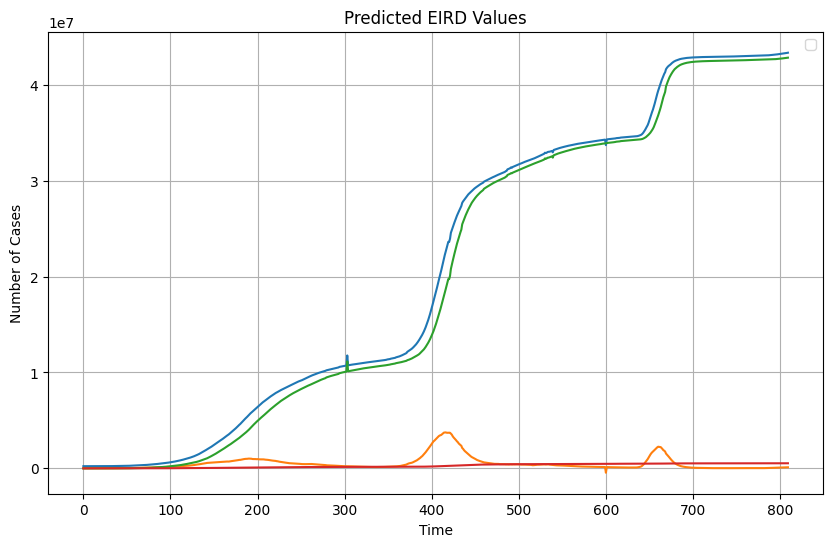

In [13]:
# Plot the EIRD graph using predicted values
plt.figure(figsize=(10, 6))

# Plot predicted values for each compartment separately
plt.plot(E_pred_denormalized )
plt.plot(I_pred_denormalized )
plt.plot(R_pred_denormalized )
plt.plot(D_pred_denormalized )

plt.title('Predicted EIRD Values')
plt.xlabel('Time')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.show()
